# Мультиколлинеарность
Идентификация основана на

* $VIF_j=\frac{1}{1-R^2_j}$
* корреляциях между регрессорами

In [45]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_params # вывод результатов тестирования
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF# VIF
import patsy # матрицы регрессионного дизайна
import seaborn as sns # Визуализация

## Sleep equation
Для набора данных `sleep75` рассмотрим линейную регрессию **sleep на totwrk/100, totwrk^2/10000, age, smsa, male, south**.

Результаты подгонки и t-тестя для коэффициентов

In [46]:
sleep_df = pd.read_csv('https://raw.githubusercontent.com/artamonoff/Econometrica/master/python-notebooks/data-csv/sleep75.csv')
specification = 'sleep~I(totwrk/100)+I(totwrk**2/10000)+age+smsa+male+south'
mod = smf.ols(formula=specification, data=sleep_df).fit()
summary_params(mod)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,3414.144351,76.730347,44.495359,4.193054e-206,3263.494784,3564.793919
I(totwrk / 100),-9.403265,4.807369,-1.956011,5.086179e-02,-18.841878,0.035347
I(totwrk ** 2 / 10000),-0.189875,0.111188,-1.707691,8.813776e-02,-0.408177,0.028428
age,2.838689,1.383128,2.052369,4.050571e-02,0.123105,5.554273
smsa,-60.523328,32.951843,-1.836721,6.667560e-02,-125.219776,4.173120
male,90.709723,34.155108,2.655817,8.091988e-03,23.650828,157.768617
south,92.451937,41.825526,2.210419,2.739925e-02,10.333222,174.570652


In [47]:
# Матрицы регрессионного дизайна
y, X = patsy.dmatrices(specification, sleep_df, return_type='dataframe')
X.head()

,Intercept,I(totwrk / 100),I(totwrk ** 2 / 10000),age,smsa,male,south
0,1.0,34.38,1181.9844,32.0,0.0,1.0,0.0
1,1.0,50.20,2520.0400,31.0,0.0,1.0,1.0
2,1.0,28.15,792.4225,44.0,1.0,1.0,0.0
3,1.0,37.86,1433.3796,30.0,0.0,0.0,0.0
4,1.0,25.80,665.6400,64.0,0.0,1.0,0.0


### Корреляции между регрессорами

In [48]:
# Удалим первый столбец с единицами
# X.drop(labels='Intercept', axis=1)
# Корреляционная матрицы для регрессоров
X.drop(labels='Intercept', axis=1).corr().round(3)

,I(totwrk / 100),I(totwrk ** 2 / 10000),age,smsa,male,south
I(totwrk / 100),1.000,0.937,-0.050,-0.038,0.376,0.051
I(totwrk ** 2 / 10000),0.937,1.000,-0.046,-0.051,0.351,0.018
age,-0.050,-0.046,1.000,0.025,0.032,-0.018
smsa,-0.038,-0.051,0.025,1.000,0.007,-0.238
male,0.376,0.351,0.032,0.007,1.000,-0.034
south,0.051,0.018,-0.018,-0.238,-0.034,1.000


<Axes: >

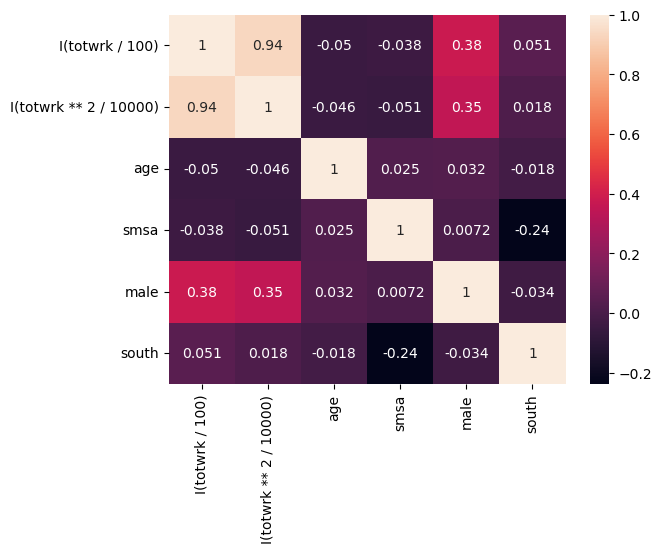

In [49]:
# Визуализация корреляционной матрицы
sns.heatmap(X.drop(labels='Intercept', axis=1).corr(), annot=True)

**Вывод**: есть сильная корреляция между 

### Variance Inflation Factors для регрессоров

Вычислим [VIF](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html) для totwrk/100, totwrk,2 / 10000 (индексы 1 и 2 в матрице дизайна для регрессоров)

In [54]:
VIF(exog=X, exog_idx=1), VIF(exog=X, exog_idx=2)

(8.48007551271243, 8.280111865499434)

In [52]:
# Непосредственное вычисление VIF
var = 'I(totwrk / 100)'
mod_aux = sm.OLS(X[var], X.drop(labels=var, axis=1) ).fit()
1/(1-mod_aux.rsquared)

8.48007551271243

### Последствия
Значимость totwrk/100, totwrk^2/10000 (t-тест)

In [55]:
mod.t_test('I(totwrk / 100)=0, I(totwrk ** 2 / 10000)=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -9.4033      4.807     -1.956      0.051     -18.842       0.035
c1            -0.1899      0.111     -1.708      0.088      -0.408       0.028

Совместная значимость (F-тест): $H_0:\beta_{totwrk/100}=\beta_{totwrk^2/10000}=0$

In [56]:
mod.f_test('I(totwrk / 100)=I(totwrk ** 2 / 10000)=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=46.640706224692366, p=9.691681941476581e-20, df_denom=699, df_num=2>